_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*FILL IN YOUR NAMES HERE* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Coding Lab 3

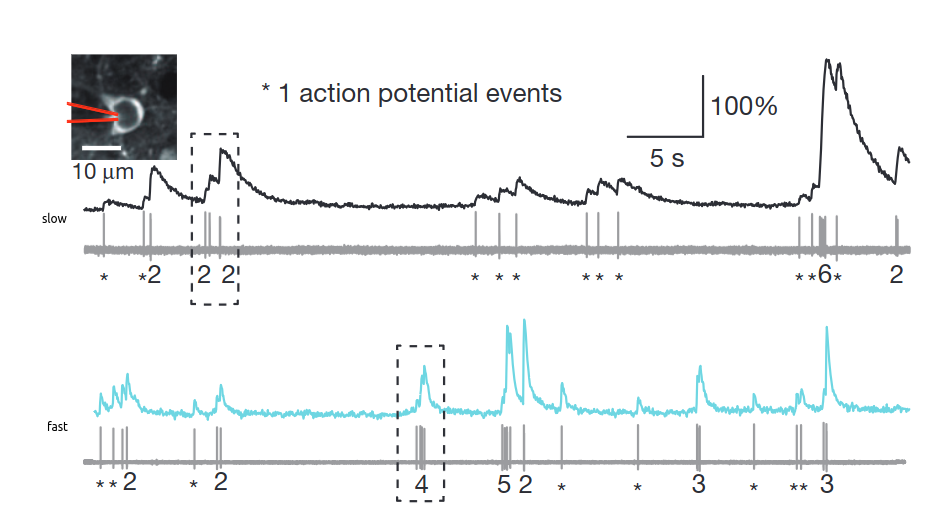

In this notebook you will work with 2 photon calcium recordings from mouse V1 and retina. For details see [Chen et al. 2013](https://www.nature.com/articles/nature12354) and [Theis et al. 2016](https://www.cell.com/neuron/pdf/S0896-6273(16)30073-3.pdf). Two-photon imaging is widely used to study computations in populations of neurons. 

In this exercise sheet we will study properties of different indicators and work on methods to infer spikes from calcium traces. All data is provided at a sampling rate of 100 Hz. For easier analysis, please resample it to 25 Hz. `scipy.signal.decimate` can help here, but note that it is only meant for continous signals. 

__Data__: Download the data file ```nds_cl_3_*.csv``` from ILIAS and save it in a subfolder ```../data/```. Note, some recordings were of shorter duration, hence their columns are padded. 

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from __future__ import annotations

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2025-05-08 08:19:51Mitteleuropäische Sommerzeit

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.17.2

sklearn: 1.3.2

matplotlib: 3.8.2
seaborn   : 0.13.0
numpy     : 1.24.3
pandas    : 2.1.3
scipy     : 1.11.3

Watermark: 2.5.0



In [40]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [41]:
# ogb dataset from Theis et al. 2016 Neuron
ogb_calcium = pd.read_csv("../data/nds_cl_3_ogb_calcium.csv", header=0)
ogb_spikes = pd.read_csv("../data/nds_cl_3_ogb_spikes.csv", header=0)
print(f"[OGB] calcium: {ogb_calcium.shape}, spikes: {ogb_spikes.shape}")

# gcamp dataset from Chen et al. 2013 Nature
gcamp_calcium = pd.read_csv("../data/nds_cl_3_gcamp2_calcium.csv", header=0)
gcamp_spikes = pd.read_csv("../data/nds_cl_3_gcamp2_spikes.csv", header=0)
print(f"[GCaMP] calcium: {gcamp_calcium.shape}, spikes: {gcamp_spikes.shape}")

# spike dataframe
ogb_spikes.head()

[OGB] calcium: (71986, 11), spikes: (71986, 11)
[GCaMP] calcium: (23973, 37), spikes: (23973, 37)


,0,1,2,3,4,5,6,7,8,9,10
0,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
1,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
2,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
3,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
4,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0


calcium data (e.g., ogb_calcium, gcamp_calcium) contains fluorescence signals over time from calcium indicators (OGB-1 or GCaMP). These are indirect proxies for neuronal activity.

spikes data (e.g., ogb_spikes, gcamp_spikes) contains the ground-truth spike times for the corresponding neurons, usually obtained via simultaneous electrophysiological recordings.

In [42]:
gcamp_spikes.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Task 1: Visualization of calcium and spike recordings

We start again by plotting the raw data - calcium and spike traces in this case. One dataset has been recorded using the synthetic calcium indicator OGB-1 at population imaging zoom (~100 cells in a field of view) and the other one using the genetically encoded indicator GCamp6f zooming in on individual cells. Plot the traces of an example cell from each dataset to show how spikes and calcium signals are related. A good example cell for the OGB-dataset is cell 5. For the CGamp-dataset a good example is cell 6. Align the traces by eye (add a small offset to the plot) such that a valid comparison is possible and zoom in on a small segment of tens of seconds.

*Grading: 3 pts*

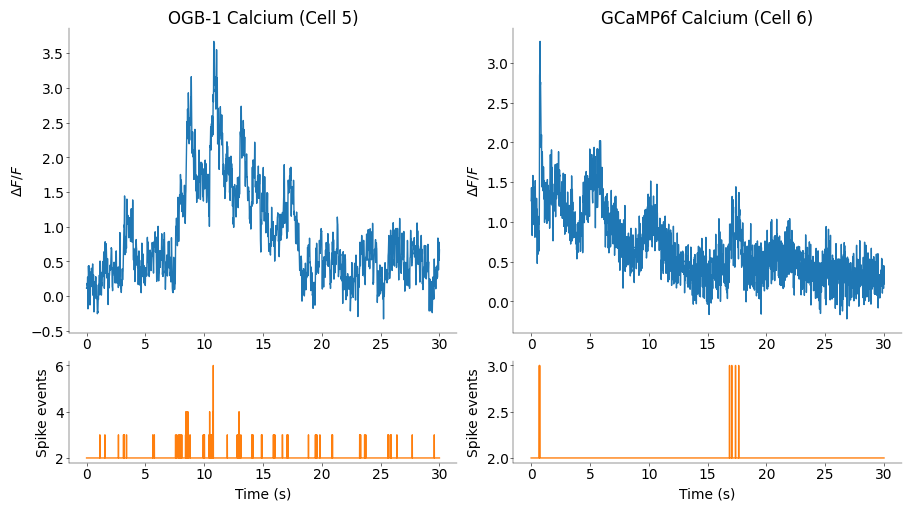

In [43]:
# --------------------------------
# Resample and prepare data (1 pt)
# --------------------------------

offsets = [1.0, 1.5, 2.0]
scales = [0.2, 0.3, 0.4]

# Sampling rate in Hz
fs = 100

# Duration and start times for segment selection
segment_duration = 30  # seconds

# Good example cells
ogb_cell = 5  # Cell 5 for OGB
gcamp_cell = 6  # Cell 6 for GCaMP

# Start times for each dataset (chosen to show clear activity)
ogb_start_s = 30
gcamp_start_s = 160

# Convert to frame indices
ogb_start_idx = ogb_start_s * fs
gcamp_start_idx = gcamp_start_s * fs
segment_length = segment_duration * fs

# Extract 30s segment from each
ogb_ca_segment = ogb_calcium.iloc[
    ogb_start_idx : ogb_start_idx + segment_length, ogb_cell
]
ogb_sp_segment = ogb_spikes.iloc[
    ogb_start_idx : ogb_start_idx + segment_length, ogb_cell
]
gcamp_ca_segment = gcamp_calcium.iloc[
    gcamp_start_idx : gcamp_start_idx + segment_length, gcamp_cell
]
gcamp_sp_segment = gcamp_spikes.iloc[
    gcamp_start_idx : gcamp_start_idx + segment_length, gcamp_cell
]

# Create time axis in seconds
time_segment = np.linspace(0, segment_duration, segment_length)

# Plot the traces
fig, axs = plt.subplots(
    2, 2, figsize=(9, 5), height_ratios=[3, 1], layout="constrained"
)

# --------------------
# Plot OGB calcium and spikes
# --------------------
axs[0, 0].plot(time_segment, ogb_ca_segment, color="C0")
axs[0, 0].set_title("OGB-1 Calcium (Cell 5)")
axs[0, 0].set_ylabel(r"$\Delta F / F$")
# when do I know if an offset is good?
axs[1, 0].plot(time_segment, ogb_sp_segment + 2, color="C1", label="Spikes (offset)")
axs[1, 0].set_ylabel("Spike events")
axs[1, 0].set_xlabel("Time (s)")

# ----------------------
# Plot GCaMP calcium and spikes
# ----------------------
axs[0, 1].plot(time_segment, gcamp_ca_segment, color="C0")
axs[0, 1].set_title("GCaMP6f Calcium (Cell 6)")
axs[0, 1].set_ylabel(r"$\Delta F / F$")
# when do I know if an offset is good?
axs[1, 1].plot(time_segment, gcamp_sp_segment + 2, color="C1", label="Spikes (offset)")
axs[1, 1].set_ylabel("Spike events")
axs[1, 1].set_xlabel("Time (s)")

plt.show()

# millisekunden

## Bonus Task (Optional): Calcium preprocessing

To improve the quality of the inferred spike trains, further preprocessing steps can undertaken. This includes filtering and smoothing of the calcium trace.

Implement a suitable filter and local averaging procedure as discussed in the lecture. Explain your choices and discuss how it helps!

_Grading: 1 BONUS point_

_BONUS Points do not count for this individual coding lab, but sum up to 5% of your **overall coding lab grade**. There are 4 BONUS points across all coding labs._

C:\Users\famdi\AppData\Local\Temp\ipykernel_20728\2768688922.py:64: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


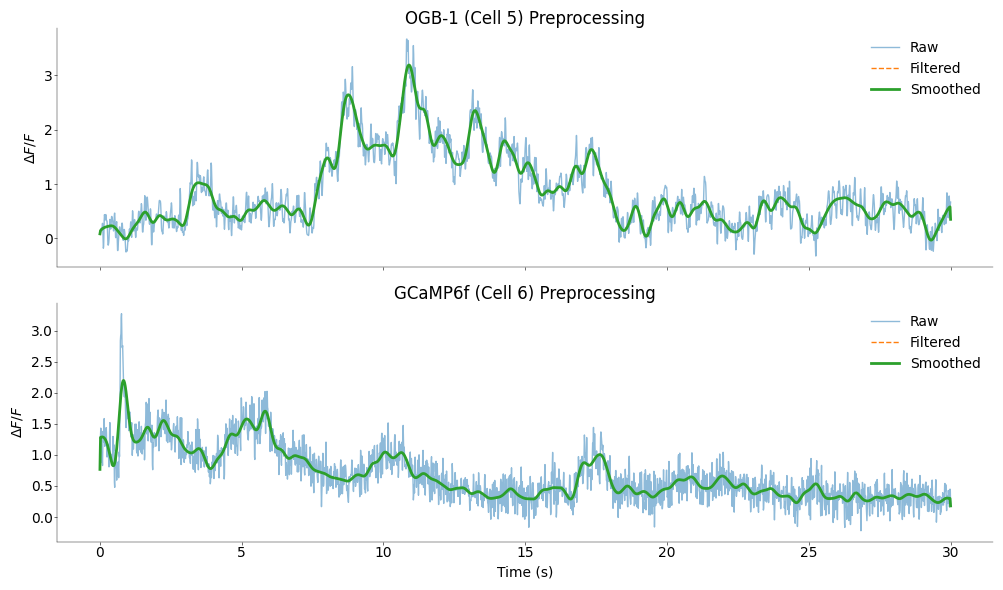

In [44]:
# apply to entire dataframe or only to segment to show how ti works?


from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

# -----------------------------
# Butterworth low-pass filter
# -----------------------------


# Define preprocessing functions
def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype="low", analog=False)
    return filtfilt(b, a, data)


# -----------------------------
# Local averaging (smoothing)
# -----------------------------


def smooth_trace(trace, window_size):
    return np.convolve(trace, np.ones(window_size) / window_size, mode="same")


# Preprocessing parameters
fs = 100
cutoff = 2.0  # Hz
window_size = 5

# Apply to OGB-1 Cell 5
ogb_raw = ogb_ca_segment.values
ogb_filtered = butter_lowpass_filter(ogb_raw, cutoff, fs)
ogb_smoothed = smooth_trace(ogb_filtered, window_size)

# Apply to GCaMP6f Cell 6
gcamp_raw = gcamp_ca_segment.values
gcamp_filtered = butter_lowpass_filter(gcamp_raw, cutoff, fs)
gcamp_smoothed = smooth_trace(gcamp_filtered, window_size)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# OGB-1
axs[0].plot(time_segment, ogb_raw, label="Raw", alpha=0.5)
axs[0].plot(time_segment, ogb_filtered, label="Filtered", linestyle="--")
axs[0].plot(time_segment, ogb_smoothed, label="Smoothed", linewidth=2)
axs[0].set_title("OGB-1 (Cell 5) Preprocessing")
axs[0].set_ylabel(r"$\Delta F / F$")
axs[0].legend()

# GCaMP6f
axs[1].plot(time_segment, gcamp_raw, label="Raw", alpha=0.5)
axs[1].plot(time_segment, gcamp_filtered, label="Filtered", linestyle="--")
axs[1].plot(time_segment, gcamp_smoothed, label="Smoothed", linewidth=2)
axs[1].set_title("GCaMP6f (Cell 6) Preprocessing")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel(r"$\Delta F / F$")
axs[1].legend()

plt.tight_layout()
plt.show()

## Task 2: Simple deconvolution

It is clear from the above plots that the calcium events happen in relationship to the spikes. As a first simple algorithm implement a deconvolution approach like presented in the lecture in the function `deconv_ca`. Assume an exponential kernel where the decay constant depends on the indicator ($\tau_{OGB}= 0.5 s$, $\tau_{GCaMP}= 0.1 s$). Note there can be no negative rates! Plot the kernel as well as an example cell with true and deconvolved spike rates. Scale the signals such as to facilitate comparisons. You can use functions from `scipy` for this. Explain your results and your choice of kernel.

*Grading: 6 pts*


In [45]:
def deconv_ca(ca: np.ndarray, tau: float, dt: float) -> np.ndarray:
    """Compute the deconvolution of the calcium signal.

    Parameters
    ----------

    ca: np.array, (n_points,)
        Calcium trace

    tau: float
        decay constant of conv kernel

    dt: float
        sampling interval.

    Return
    ------

    sp_hat: np.array
    """

    # --------------------------------------------
    # apply devonvolution to calcium signal (1 pt)
    # --------------------------------------------
    # Defining the parameters
    n_points = ca.shape[0]
    T_s = 30
    t_s = np.linspace(0, T_s, int(T_s / dt))

    # Defining the kernel
    exponential_kernel = np.exp(-t_s / tau)

    # Extracting the deconvolved signal
    sp_hat_raw, _ = signal.deconvolve(ca, exponential_kernel)

    # Restricting the signal to positive values
    sp_hat_raw[sp_hat_raw < 0] = 0

    # Done due to issues in task 4
    sp_hat = np.zeros(n_points)
    sp_hat[: sp_hat_raw.shape[0]] = sp_hat_raw

    return sp_hat

In [46]:
# adjust rest of code based on downsampling, think about downsampling, should it be done or not?


# Defining the desired sampling rate and calculating the downsampling factor
fs_new = 25
downsampling_factor = int(fs / fs_new)

# Downsampling the recordings
# OGB-1
downsampled_ogb_calcium = ogb_calcium.apply(
    lambda cell: signal.decimate(cell, downsampling_factor)
)
downsampled_ogb_spikes = ogb_spikes.apply(
    lambda cell: signal.decimate(cell, downsampling_factor)
)

# Not considering negative values (as in the forum)
downsampled_ogb_spikes[downsampled_ogb_spikes < 0] = 0

# GCamp6f
downsampled_gcamp_calcium = gcamp_calcium.apply(
    lambda cell: signal.decimate(cell, downsampling_factor)
)
downsampled_gcamp_spikes = gcamp_spikes.apply(
    lambda cell: signal.decimate(cell, downsampling_factor)
)
downsampled_gcamp_spikes[downsampled_gcamp_spikes < 0] = 0

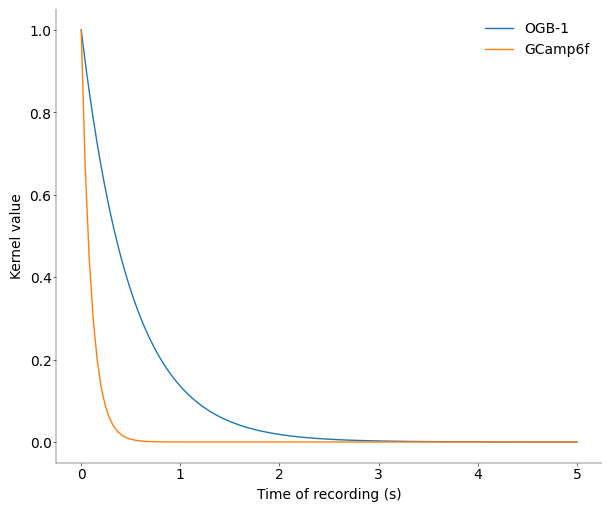

In [47]:
fig, ax = plt.subplots(figsize=(6, 5), layout="constrained")

# -------------------------
# Plot the 2 kernels (1 pt)
# -------------------------

# Determine the parameters
dt = 1 / fs_new
T_s = 5
t_s = np.linspace(0, T_s, int(T_s / dt))

# OGB-1 kernel
tau_ogb = 0.5
ogb_kernel = np.exp(-t_s / tau_ogb)

# GCamp6f kernel
tau_gcamp = 0.1
gcamp_kernel = np.exp(-t_s / tau_gcamp)

# Plotting both kernels
ax.plot(t_s, ogb_kernel, color="C0", label="OGB-1")
ax.plot(t_s, gcamp_kernel, color="C1", label="GCamp6f")

ax.set_xlabel("Time of recording (s)")
ax.set_ylabel("Kernel value")
ax.legend()
plt.show()

### Questions (1 pt)
1) Explain how you constructed the kernels

YOUR ANSWER HERE

2) How do the indicators / kernels compare?

YOUR ANSWER HERE

3) What are pros and cons of each indicator?

YOUR ANSWER HERE

c:\Users\famdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\signal\_signaltools.py:2293: RuntimeWarning: Use of fft convolution on input with NAN or inf results in NAN or inf output. Consider using method='direct' instead.
  rem = num - convolve(den, quot, mode='full')


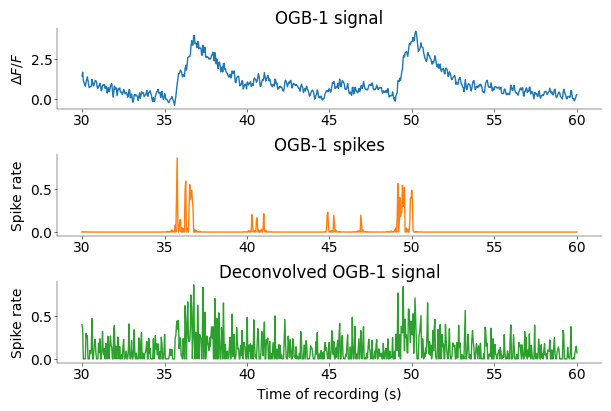

In [53]:
# ----------------------------------------------------------------------
# Compare true and deconvolved spikes rates for the OGB and GCamP cells.
# What do you notice? Why is that? (3 pts)
# ----------------------------------------------------------------------

# fig, axs = plt.subplots(
# 3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
# )

# OGB Cell

# fig, axs = plt.subplots(
#  3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
# )

# GCamp Cell


# --------------------------------------------------------------------------
# Compare true and deconvolved spikes rates for the OGB or GCamP Cell (1 pt)
# --------------------------------------------------------------------------
# Parameters
# tau_ogb = 0.5
# fs_new = 25
# dt = 1 / fs_new
ogb_cell = 5
ogb_T_start_s = 30
T_s = 30
ogb_T_end_s = ogb_T_start_s + T_s


fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# OGB Cell
# Determining the deconvolved signal
deconvolved_ogb_calcium = downsampled_ogb_calcium.apply(
    lambda cell: deconv_ca(cell, tau=tau_ogb, dt=1 / fs_new)
)

# Defining new time spans
ogb_t_s_new = np.linspace(
    ogb_T_start_s, ogb_T_end_s, int((ogb_T_end_s - ogb_T_start_s) * fs_new)
)

# Plotting the signals and spike rates
axs[0].plot(
    ogb_t_s_new,
    downsampled_ogb_calcium.iloc[
        int(ogb_T_start_s * fs_new) : int(ogb_T_end_s * fs_new), 4
    ],
    color="C0",
)
axs[0].set_title("OGB-1 signal")
axs[0].set_ylabel(r"$\Delta F / F$")

axs[1].plot(
    ogb_t_s_new,
    downsampled_ogb_spikes.iloc[
        int(ogb_T_start_s * fs_new) : int(ogb_T_end_s * fs_new), 4
    ],
    color="C1",
)
axs[1].set_title("OGB-1 spikes")
axs[1].set_ylabel("Spike rate")

axs[2].plot(
    ogb_t_s_new,
    deconvolved_ogb_calcium.iloc[
        int(ogb_T_start_s * fs_new) : int(ogb_T_end_s * fs_new), 4
    ],
    color="C2",
)
axs[2].set_title("Deconvolved OGB-1 signal")
axs[2].set_xlabel("Time of recording (s)")
axs[2].set_ylabel("Spike rate")

plt.show()

## Task 3: Run more complex algorithm

As reviewed in the lecture, a number of more complex algorithms for inferring spikes from calcium traces have been developed. Run an implemented algorithm on the data and plot the result. There is a choice of algorithms available, for example:

* Vogelstein: [oopsi](https://github.com/liubenyuan/py-oopsi)
* Theis: [c2s](https://github.com/lucastheis/c2s)
* Friedrich: [OASIS](https://github.com/j-friedrich/OASIS)

*Grading: 3 pts*



In [ ]:
# run this cell to download the oopsi.py file and put it in the same folder as this notebook
!wget https://raw.githubusercontent.com/liubenyuan/py-oopsi/master/oopsi.py
import oopsi

In [ ]:
# ----------------------------------------------------------------------
# Apply one of the advanced algorithms to the OGB and GCamp Cells (1 pt)
# ----------------------------------------------------------------------

In [ ]:
# -------------------------------------------------------------------------------
# Plot the results for the OGB and GCamp Cells and describe the results (1+1 pts)
# -------------------------------------------------------------------------------

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# OGB Cell

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# GCamP Cell

## Task 4: Evaluation of algorithms

To formally evaluate the algorithms on the two datasets run the deconvolution algorithm and the more complex one on all cells and compute the correlation between true and inferred spike trains. `DataFrames` from the `pandas` package are a useful tool for aggregating data and later plotting it. Create a dataframe with columns

* algorithm
* correlation
* indicator

and enter each cell. Plot the results using `stripplot` and/or `boxplot` in the `seaborn` package. Note these functions provide useful options for formatting the
plots. See their documentation, i.e. `sns.boxplot?`.

*Grading: 5 pts*


First, evaluate on OGB data and create OGB dataframe. Then repeat for GCamp and combine the two dataframes.

In [ ]:
# ----------------------------------------------------------
# Evaluate the algorithms on the OGB and GCamp cells (2 pts)
# ----------------------------------------------------------

In [ ]:
# -------------------------------
# Construct the dataframe (1 pts)
# -------------------------------

Combine both dataframes. Plot the performance of each indicator and algorithm. You should only need a single plot for this.

In [ ]:
# ----------------------------------------------------------------------------
# Create Strip/Boxplot for both cells and algorithms Cell as described. (1 pt)
# Describe and explain the results briefly. (1 pt)
# ----------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 6), layout="constrained")
